In [1]:
import os
import numpy as np

import tensorflow as tf
import tensorflow_addons as tfa
gpus = tf.config.experimental.list_physical_devices('GPU')
# I think the below should be commented out
# for gpu in gpus:
#       tf.config.experimental.set_memory_growth(gpu, True)
print(tf.__version__)
AUTOTUNE = tf.data.experimental.AUTOTUNE

import deepcell
# Changed from before due to new placement of Track, concat_tracks
from deepcell_tracking.utils import load_trks
from deepcell.data.tracking import Track, concat_tracks
##############
from sklearn.model_selection import train_test_split
from deepcell.utils.data_utils import reshape_movie
from deepcell.utils.transform_utils import erode_edges
from deepcell.data import split_dataset
from deepcell_toolbox.processing import normalize, histogram_normalization

import spektral

2022-12-18 02:13:10.675734: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-18 02:13:10.683679: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-18 02:13:10.683986: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


2.8.0


# Load dictionaries of usable (non-blank, non-border) images

In [2]:
import json
def load_img_dict(file):
    f = open(file)
    d = json.load(f)
    d = {int(k1): {int(k2): {int(k3): v for k3, v in d[k1][k2].items()} for k2, d[k1][k2] in d[k1].items()} for k1, d[k1] in d.items()}
    return d
def load_img_idx_dict(file):
    f = open(file)
    d = json.load(f)
    d = {int(k): v for k, v in d.items()}
    return d

In [3]:
# Of the form {batch: {cell: {frame: -1/idx, ...}, ...}, ...} where good_imgs[batch][cell][frame] = -1 if the image
# is blank/on the border and idx if it is usable, where idx is the position in the list of usable images
train_good_imgs = load_img_dict('/data/dataset_pruning/train_appearances_dict.json')
train_blank_imgs = load_img_dict('/data/dataset_pruning/train_blank_dict.json')
train_border_imgs = load_img_dict('/data/dataset_pruning/train_border_dict.json')
val_good_imgs = load_img_dict('/data/dataset_pruning/val_appearances_dict.json')
val_blank_imgs = load_img_dict('/data/dataset_pruning/val_blank_dict.json')
val_border_imgs = load_img_dict('/data/dataset_pruning/val_border_dict.json')

In [4]:
def get_lst_idx_to_pos(good_imgs_dict):
    lst_idx_to_pos = {}
    for b in good_imgs_dict.keys():
        for c in good_imgs_dict[b].keys():
            for f in good_imgs_dict[b][c].keys():
                idx = good_imgs_dict[b][c][f]
                if idx != -1:
                    lst_idx_to_pos = (b, f, c)
    return lst_idx_to_pos

# Dictionary of frames to split (time until splitting) for each image, in the format of usable image dictionary
def get_life_cycle_dict(tracks):
    batches, frames, cells = tracks.centroids.shape[:3]
    
    life_cycle_dict = {}
    for batch in range(batches):
        life_cycle_dict[batch] = {}
        for cell in range(cells):
            life_cycle_dict[batch][cell] = {}
            for frame in range(frames):
                life_cycle_dict[batch][cell][frame] = -1
    
    for batch in range(batches):
        for cell in tracks.lineages[batch].keys():
            if len(tracks.lineages[batch][cell]['daughters']) != 0:
                cell_frames = tracks.lineages[batch][cell]['frames']
                last_frame = cell_frames[-1]
                for cell_frame in cell_frames:
                    life_cycle_dict[batch][cell - 1][cell_frame] = last_frame - cell_frame + 1
    
    return life_cycle_dict

# Should the cells in the dictionary be 0-indexed? What is the case in the good_imgs_dict?
# Yes. It is 0-indexed wrt the cells

# Write appearances array to TF Records

In [5]:
import csv
import os

from tensorflow.data import Dataset
from tensorflow.io import serialize_tensor
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.backend import is_sparse

def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        # BytesList won't unpack a string from an EagerTensor.
        value = value.numpy()
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))


def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def serialize_array(array):
    array = tf.io.serialize_tensor(array)
    return array

def create_tracking_example(image):
    # define the dictionary -- the structure -- of our single example
    data = {
        'height' : _int64_feature(image.shape[0]),
        'width' : _int64_feature(image.shape[1]),
        'depth' : _int64_feature(image.shape[2]),
        'raw_image' : _bytes_feature(serialize_array(image))
    }
    # create an Example, wrapping the single features
    out = tf.train.Example(features=tf.train.Features(feature=data))
    
    return out

In [10]:
# No (extra) normalization
def write_tracking_dataset_to_tfr(track, filename, good_imgs):
    print('Done calculating normalizations.')
    filename = "/tf_records/" + filename + ".tfrecords"
    writer = tf.io.TFRecordWriter(filename) #create a writer that'll store our data to disk
    count = 0

    app = track.appearances
    # Only write usable images to the record
    for b in range(app.shape[0]):
        print(b)
        for f in range(app.shape[1]):
            for c in range(app.shape[2]):
                # Check if the given image is usable
                if good_imgs[b][c][f] != -1:
                    current_image = app[b, f, c]

                    out = create_tracking_example(current_image)

                    if out is not None:
                        writer.write(out.SerializeToString())
                        count += 1

    writer.close()
    print(f'Wrote {count} elements to TFRecord')
    return count

In [2]:
# train_trks = load_trks(os.path.join('/data/tracking-nuclear', 'train.trks'))
val_trks = load_trks(os.path.join('/data/tracking-nuclear', 'val.trks'))

In [8]:
train_life_cycle_dict = get_life_cycle_dict(train_tracks)
val_life_cycle_dict = get_life_cycle_dict(val_tracks)

NameError: name 'train_tracks' is not defined

In [3]:
with tf.device('/cpu:0'):
    val_tracks = Track(tracked_data=val_trks,
                   appearance_dim=64,
                   distance_threshold=64,
                   crop_mode='fixed')

    print('Done creating Track objects.')

#     write_tracking_dataset_to_tfr(val_tracks, filename='val_big_std_norm', good_imgs=val_good_imgs)

2022-12-14 02:03:22.864402: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-14 02:03:23.522140: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10415 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:09:00.0, compute capability: 6.1
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [03:10<00:00,  7.06s/it]


Done creating Track objects.


In [12]:
with tf.device('/cpu:0'):
    train_tracks = Track(tracked_data=train_trks,
                   appearance_dim=64,
                   distance_threshold=64,
                   crop_mode='fixed')

    print('Done with creating Track objects.')

    write_tracking_dataset_to_tfr(train_tracks, filename='train_big_std_norm', good_imgs=train_good_imgs)

 33%|███████████████████████████████████████████████████████                                                                                                                | 30/91 [07:00<16:15, 15.99s/it]/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encoun

Done with creating Track objects.
Done calculating normalizations.
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
Wrote 383800 elements to TFRecord


# Load images from TF Records

In [4]:
def parse_tfr_element(element):
    #use the same structure as above; it's kinda an outline of the structure we now want to create
    data = {
        'height': tf.io.FixedLenFeature([], tf.int64),
        'width':tf.io.FixedLenFeature([], tf.int64),
        'depth':tf.io.FixedLenFeature([], tf.int64),
        'raw_image' : tf.io.FixedLenFeature([], tf.string)
    }


    content = tf.io.parse_single_example(element, data)

    height = content['height']
    width = content['width']
    depth = content['depth']
    raw_image = content['raw_image']
    

    #get our 'feature'-- our image -- and reshape it appropriately
    feature = tf.io.parse_tensor(raw_image, out_type=tf.float32)
    feature = tf.reshape(feature, shape=[height,width,depth])
    return (feature, feature)

In [5]:
def get_dataset(filename, batch_size=1, buffer_size=256,
                    seed=None):
    #create the dataset
    dataset = tf.data.TFRecordDataset(filename)

    #pass every single feature through our mapping function
    dataset = dataset.map(
      parse_tfr_element
    )
    
    dataset = dataset.shuffle(buffer_size, seed=seed)

    dataset = dataset.repeat().batch(batch_size)
    
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [6]:
val_dataset = get_dataset("/tf_records/val_big_std_norm.tfrecords", batch_size=100)
train_dataset = get_dataset("/tf_records/train_big_std_norm.tfrecords", batch_size=100)

In [7]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers
tfk = tf.keras
tfkl = tf.keras.layers

In [8]:
class VAE:
    
    def __init__(self, dim_z, kl_weight, learning_rate, n_filters, n_layers, side):
        # change dim from (28, 28, 1)
        self.dim_x = (side, side, 1)
        self.dim_z = dim_z
        self.kl_weight = kl_weight
        self.learning_rate = learning_rate
        self.n_filters = n_filters
        self.n_layers = n_layers
        self.side = side

    # Sequential API encoder
    def encoder_z(self):
        # define prior distribution for the code, which is an isotropic Gaussian
        prior = tfd.Independent(tfd.Normal(loc=tf.zeros(self.dim_z), scale=1.), 
                                reinterpreted_batch_ndims=1)
        # build layers argument for tfk.Sequential()
        input_shape = self.dim_x
        layers = [tfkl.InputLayer(input_shape=input_shape)]
        for i in range(self.n_layers):
            layers.append(tfkl.Conv2D(filters=self.n_filters, kernel_size=3, strides=(2,2), 
                                  padding='valid', activation='relu'))
        layers.append(tfkl.Flatten())
        # the following two lines set the output to be a probabilistic distribution
        layers.append(tfkl.Dense(tfpl.IndependentNormal.params_size(self.dim_z), 
                                 activation=None, name='z_params'))
        layers.append(tfpl.IndependentNormal(self.dim_z, 
            convert_to_tensor_fn=tfd.Distribution.sample, 
            activity_regularizer=tfpl.KLDivergenceRegularizer(prior, weight=self.kl_weight), 
            name='z_layer'))
        return tfk.Sequential(layers, name='encoder')
    
    # Sequential API decoder
    def decoder_x(self):
        layers = [tfkl.InputLayer(input_shape=self.dim_z)]
        # probably 7 before since 28/2/2 = 7, so changing to 32/2/2 = 8
        frac = 2**self.n_layers
        layers.append(tfkl.Dense(int((self.side/frac)**2*32), activation=None))
        layers.append(tfkl.Reshape((int(self.side/frac),int(self.side/frac),32)))
        for i in range(self.n_layers):
            layers.append(tfkl.Conv2DTranspose(filters=self.n_filters, kernel_size=3, strides=2, 
                                           padding='same', activation='relu'))
        layers.append(tfkl.Conv2DTranspose(filters=1, kernel_size=3, strides=1, 
                                           padding='same'))
        layers.append(tfkl.Flatten())
        # note that here we don't need 
        # `tfkl.Dense(tfpl.IndependentBernoulli.params_size(self.dim_x))` because 
        # we've restored the desired input shape with the last Conv2DTranspose layer
        layers.append(tfkl.Dense(tfpl.IndependentNormal.params_size(self.dim_x), 
                                 activation=None, name='x_params'))
        layers.append(tfpl.IndependentNormal(self.dim_x,
            name='x_layer'))
        return tfk.Sequential(layers, name='decoder')
    
    def build_vae_keras_model(self):
        x_input = tfk.Input(shape=self.dim_x)
        encoder = self.encoder_z()
        decoder = self.decoder_x()
        z = encoder(x_input)

        # compile VAE model
        model = tfk.Model(inputs=x_input, outputs=decoder(z))
        model.compile(loss=negative_log_likelihood, 
                      optimizer=tfk.optimizers.Adam(self.learning_rate))
        return model

# the negative of log-likelihood for probabilistic output
negative_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)

In [9]:
# VAE with 4 encoding and decoding layers, 64 filters per convolution, KL-divergence weight 1
# dim_z, kl_weight, learning_rate, n_filters, n_layers, side
vae = VAE(16, 1, 1e-3, 64, 4, 64)
AE = vae.build_vae_keras_model()

2022-12-14 02:09:00.513086: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [10]:
from tensorflow_addons.optimizers import RectifiedAdam as RAdam
from deepcell import train_utils

steps_per_epoch = 3838
validation_steps = 895
n_epochs = 8
# model_path = '/data/models/big_img_4_layers_16_embed_10_beta'

train_callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
      
        monitor='val_loss', factor=0.5, verbose=1,
        patience=3, min_lr=1e-7)#,
#     tf.keras.callbacks.ModelCheckpoint(
#         model_path, monitor='val_loss',
#         save_best_only=True, verbose=1,
#         save_weights_only=True)
]

loss_history = AE.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    epochs=n_epochs,
    verbose=1,
    callbacks=train_callbacks
)

Epoch 1/8


2022-12-14 02:11:10.743393: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100


3838/3838 [==============================] - 154s 39ms/step - loss: 638913806336.0000 - val_loss: 20480.5156 - lr: 0.0010
Epoch 2/8
3838/3838 [==============================] - 153s 40ms/step - loss: nan - val_loss: nan - lr: 0.0010
Epoch 3/8
3838/3838 [==============================] - 153s 40ms/step - loss: nan - val_loss: nan - lr: 0.0010
Epoch 4/8
3837/3838 [============================>.] - ETA: 0s - loss: nan
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
3838/3838 [==============================] - 152s 40ms/step - loss: nan - val_loss: nan - lr: 0.0010
Epoch 5/8
3838/3838 [==============================] - 152s 40ms/step - loss: nan - val_loss: nan - lr: 5.0000e-04
Epoch 6/8
3838/3838 [==============================] - 152s 40ms/step - loss: nan - val_loss: nan - lr: 5.0000e-04
Epoch 7/8
3837/3838 [============================>.] - ETA: 0s - loss: nan
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
3838/3838 [============

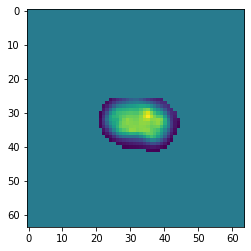

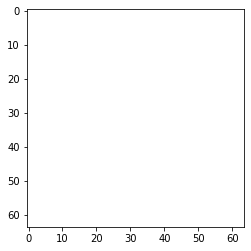

In [11]:
import matplotlib.pyplot as plt

x = np.array([val_tracks.appearances[2][13][6]])
xhat = AE(x).mean()

fig, ax = plt.subplots()
ax.imshow(x[0])

fig, ax = plt.subplots()
ax.imshow(xhat[0])

In [12]:
val_dataset = get_dataset("/data/tf_records/val_big.tfrecords", batch_size=100)
train_dataset = get_dataset("/data/tf_records/train_big.tfrecords", batch_size=100)

In [13]:
# VAE with 4 encoding and decoding layers, 64 filters per convolution, KL-divergence weight 1
# dim_z, kl_weight, learning_rate, n_filters, n_layers, side
vae2 = VAE(16, 1, 1e-3, 64, 4, 64)
AE2 = vae.build_vae_keras_model()

In [15]:
from tensorflow_addons.optimizers import RectifiedAdam as RAdam
from deepcell import train_utils

steps_per_epoch = 3838
validation_steps = 895
n_epochs = 4
# model_path = '/data/models/big_img_4_layers_16_embed_10_beta'

train_callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
      
        monitor='val_loss', factor=0.5, verbose=1,
        patience=3, min_lr=1e-7)#,
#     tf.keras.callbacks.ModelCheckpoint(
#         model_path, monitor='val_loss',
#         save_best_only=True, verbose=1,
#         save_weights_only=True)
]

loss_history = AE2.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    epochs=n_epochs,
    verbose=1,
    callbacks=train_callbacks
)

Epoch 1/4
3838/3838 [==============================] - 154s 40ms/step - loss: -5496.5293 - val_loss: 5227.3755 - lr: 0.0010
Epoch 2/4
3838/3838 [==============================] - 154s 40ms/step - loss: -6287.4819 - val_loss: 570.2474 - lr: 0.0010
Epoch 3/4
3838/3838 [==============================] - 153s 40ms/step - loss: -6690.2344 - val_loss: -1890.8573 - lr: 0.0010
Epoch 4/4
3838/3838 [==============================] - 153s 40ms/step - loss: -5318.7632 - val_loss: -2278.5364 - lr: 0.0010


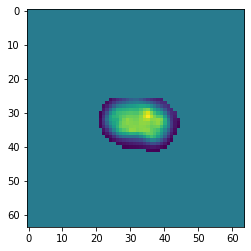

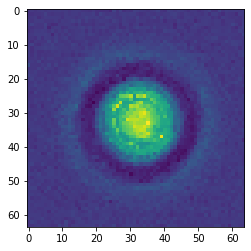

In [17]:
import matplotlib.pyplot as plt

x = np.array([val_tracks.appearances[2][13][6]])
xhat = AE2(x).mean()

fig, ax = plt.subplots()
ax.imshow(x[0])

fig, ax = plt.subplots()
ax.imshow(xhat[0])

# Run other VAE model

In [2]:
import os
import deepcell

import tensorflow as tf
import numpy as np
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

from skimage.measure import regionprops
from tqdm.notebook import tqdm
from tensorflow.keras.utils import plot_model

In [3]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer, Input, Conv2D, Conv3D, Lambda
from tensorflow.keras.layers import Flatten, Reshape, Dense, UpSampling2D, UpSampling3D 
from deepcell.layers import ImageNormalization2D


class Sampling(Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    
class ReshapeEncoder(Layer):
    def __init__(self, n_filters, **kwargs):
        super(ReshapeEncoder, self).__init__(**kwargs)
        
        self.n_filters = n_filters
        
    def call(self, inputs):
        outputs = tf.reshape(inputs, [tf.shape(inputs)[0], 
                                      tf.shape(inputs)[1], 
                                      4*4*self.n_filters])
        return outputs
    
class ReshapeDecoder(Layer):
    def __init__(self, encoder_dim, **kwargs):
        super(ReshapeDecoder, self).__init__(**kwargs)
        
        self.encoder_dim = encoder_dim
        
    def call(self, inputs):
        outputs = tf.reshape(inputs, [tf.shape(inputs)[0],
                                      tf.shape(inputs)[1],
                                      4, 4, self.encoder_dim])
        return outputs

class VAE(Model):
    def __init__(self, 
                 image_shape=(None,64,64,1),
                 n_filters=64, 
                 encoder_dim=16,
                 observation_std=0.1,
                 **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.image_shape = image_shape
        self.n_filters = n_filters
        self.encoder_dim = encoder_dim
        self.observation_std = observation_std
        
        self.encoder = self.create_encoder()
        self.prob_encoder = self.create_prob_encoder()
        self.decoder = self.create_decoder()
        
        self.total_loss_tracker = tf.keras.metrics.Mean(name='total_loss')
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name='reconstruction_loss')
        self.kl_loss_tracker = tf.keras.metrics.Mean(name='kl_loss')
        
        self.build((None,) + self.image_shape)
                
    def create_encoder(self):
        encoder_input = Input(shape=self.image_shape, name='image')
        x = encoder_input
        for i in range(4):
            x = Conv3D(self.n_filters, 
                       (1,3,3), 
                       strides=(1,2,2), 
                       padding='same', 
                       activation='relu')(x)
            
        x = ReshapeEncoder(self.n_filters)(x)
        z_mean = Dense(self.encoder_dim, name='z_mean')(x)
        z_log_var = Dense(self.encoder_dim, name='z_log_var')(x)

        outputs = [z_mean, z_log_var]

        model = Model(inputs=encoder_input, outputs=outputs)
        return model

    def create_prob_encoder(self):
        z_mean_input = Input(shape=(None, self.encoder_dim), name='z_mean_input')
        z_log_var_input = Input(shape=(None, self.encoder_dim), name='z_log_var_input')
        
        x = Sampling()([z_mean_input, z_log_var_input])
        
        inputs = [z_mean_input, z_log_var_input]
        model = Model(inputs=inputs, outputs=x)
        
        return model
    
    def create_decoder(self):
        decoder_input = Input(shape=(None, self.encoder_dim,), name='decoder_input')
        x = decoder_input 

        x = Dense(4*4*self.encoder_dim)(x)        
        x = ReshapeDecoder(self.encoder_dim)(x)

        for i in range(4):
            x = UpSampling3D(size=(1,2,2))(x)
            x = Conv3D(self.n_filters, 
                       (1,3,3), 
                       strides=(1,1,1), 
                       padding='same', 
                       activation='relu')(x)
        x = Conv3D(1, 
                   (1,1,1), 
                   strides=(1,1,1), 
                   padding='same',
                   name='reconstruction',
                   dtype='float32')(x)
        
        model = Model(inputs=decoder_input, outputs=x)
        
        return model
    
    def call(self, inputs):
        encoded = self.encoder(inputs)
        prob_encoded = self.prob_encoder(encoded)
        decoded = self.decoder(prob_encoded)
        
        return decoded
        
    def gaussian_log_likelihood(self, targets, mean, std):
        se = 0.5 * tf.reduce_sum(tf.square(targets - mean)) / (2*tf.square(std)) + tf.math.log(std)
        return se        
    
    def kl_div(self, z_mean, z_log_var):
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_sum(kl_loss)
        
        return kl_loss
    
    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]
    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            reconstruction = self(data[0])
            z_mean, z_log_var = self.encoder(data[0])
            
            obs_epsilon = tf.keras.backend.random_normal(tf.shape(reconstruction))
            observation = reconstruction + self.observation_std * obs_epsilon
            reconstruction_loss = self.gaussian_log_likelihood(data[1]['reconstruction'], 
                                                               observation,
                                                               self.observation_std)
            
            kl_loss = self.kl_div(z_mean, z_log_var)
            total_loss = reconstruction_loss + kl_loss
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {
            'loss': self.total_loss_tracker.result(),
            'reconstruction_loss': self.reconstruction_loss_tracker.result(),
            'kl_loss': self.kl_loss_tracker.result()
        }

In [4]:
vae_model = VAE()

2022-12-18 02:13:51.523103: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-18 02:13:51.526223: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-18 02:13:51.526670: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-18 02:13:51.526986: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

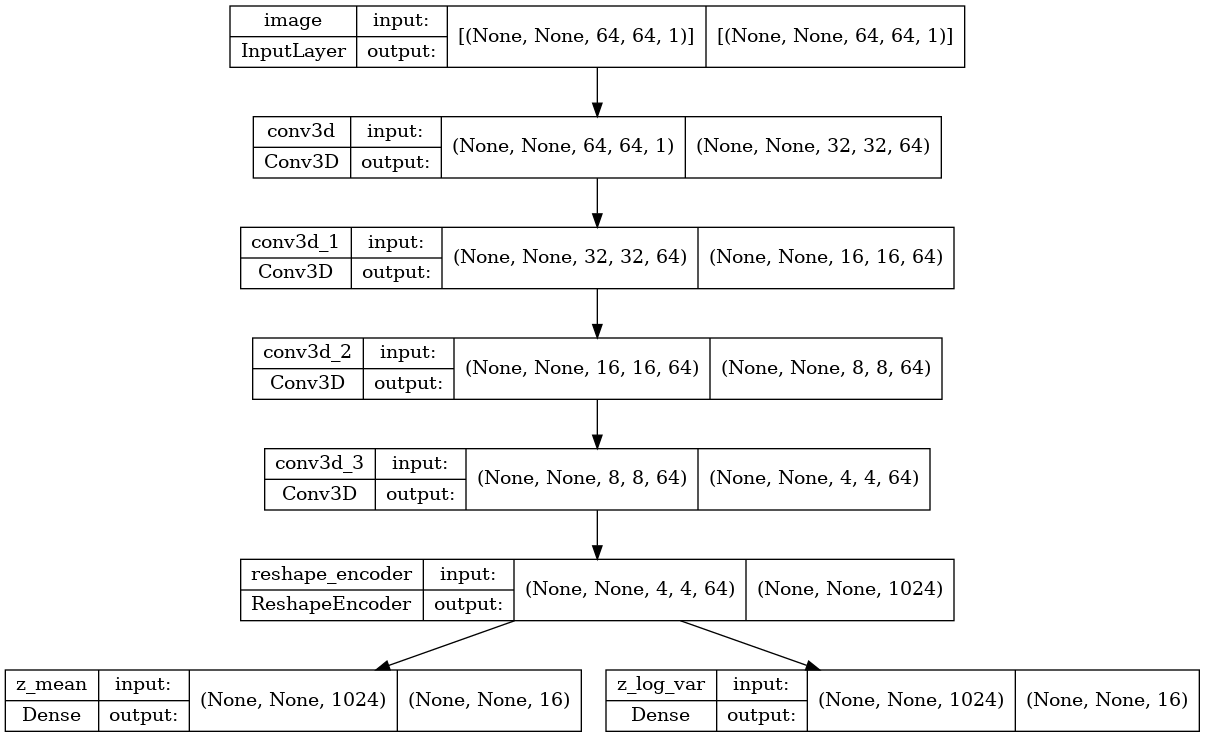

In [5]:
plot_model(vae_model.encoder, show_shapes=True)

In [6]:
from tensorflow_addons.optimizers import RectifiedAdam as RAdam

# Define optimizer
optimizer = RAdam(learning_rate=1e-3, clipnorm=0.001)

# Compile model
vae_model.compile(optimizer=optimizer)

In [7]:
n_epochs = 8
steps_per_epoch = 4096

In [8]:
def create_appearance_dataset(train_path, crop_size=64):
    trk_data = load_trks(train_path)
    X = trk_data['X'].astype('float32')
    y = trk_data['y']
    
    # Zero-pad the X array
    pad_width = ((0,0),
                 (0,0),
                 (crop_size, crop_size),
                 (crop_size, crop_size), 
                 (0,0))
    X = np.pad(X, pad_width=pad_width)
    y = np.pad(y, pad_width=pad_width)
    
    appearance_list = []
    for b in tqdm(range(X.shape[0])):
        for t in range(X.shape[1]):
            Xbt = X[b,t]
            ybt = y[b,t]
            
            props = regionprops(ybt[...,0])
            for i, prop in enumerate(props):
                centroid = np.array(prop.centroid)
                delta = crop_size // 2
                minr = int(centroid[0])-delta
                maxr = int(centroid[0])+delta
                minc = int(centroid[1])-delta
                maxc = int(centroid[1])+delta 
                
                app = np.copy(Xbt[minr:maxr, minc:maxc, :])
                label = np.copy(ybt[minr:maxr, minc:maxc])
                
                app = app * (label==prop.label)
                
                idx = np.nonzero(app)
                
                if len(idx) > 0:
                    mean = np.mean(app[np.nonzero(app)])
                    std = np.std(app[np.nonzero(app)])
        
                    app[np.nonzero(app)] = (app[np.nonzero(app)] - mean) / std
            
                    appearance_list.append(app)
                
    appearances = np.stack(appearance_list, axis=0)
    
    return appearances

In [9]:
train_path = os.path.join('/data', 'train.trks')
val_path = os.path.join('/data', 'val.trks')

In [10]:
%%time
appearances = create_appearance_dataset(train_path)

  0%|          | 0/91 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


CPU times: user 4min 26s, sys: 17 s, total: 4min 43s
Wall time: 4min 43s


In [13]:
def augment(*args, rotation_range=180):
    X_dict = args[0]
    y_dict = args[1]
    
    img = X_dict['image']
    rg = rotation_range * np.pi / 180
    theta = tf.random.uniform(shape=[1], minval=-rg, maxval=rg)
    img = tfa.image.rotate(img, theta)
    
    img = tf.expand_dims(img, axis=1)
    
    X_dict['image'] = img
    y_dict['reconstruction'] = img
    
    return X_dict, y_dict

appearances = appearances.astype('float32')
train_data = tf.data.Dataset.from_tensor_slices(({'image':appearances}, {'reconstruction':appearances}))
train_data = train_data.shuffle(256).repeat().batch(16).map(augment, num_parallel_calls=tf.data.AUTOTUNE)

In [14]:
train_iter = iter(train_data)

(16, 1, 64, 64, 1)
0.0020207958 0.0020207958


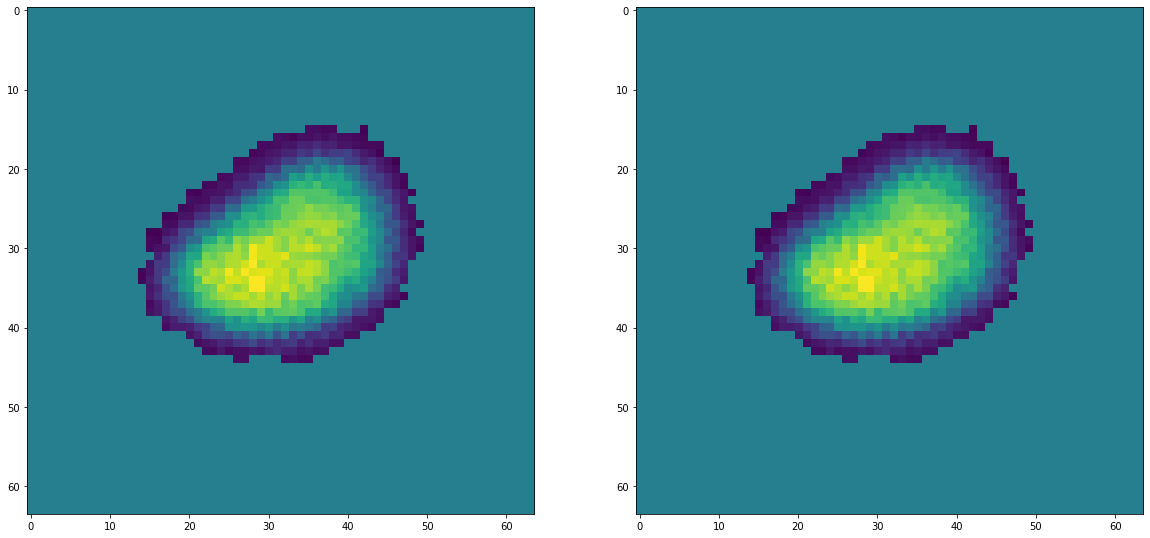

In [15]:
X, y = train_iter.next()
img = X['image']
rec = y['reconstruction']
fig, axes = plt.subplots(1,2,figsize=(20,20))
print(img.shape)
axes[0].imshow(img[0,0,:,:,0])
axes[1].imshow(rec[0,0,:,:,0])

print(np.mean(img[0,0,:,:,0]), np.mean(rec[0,0,:,:,0]))

In [16]:
loss_history = vae_model.fit(
    train_data,
    steps_per_epoch=steps_per_epoch,
    epochs=n_epochs,
    verbose=1)

Epoch 1/8


2022-12-18 02:26:58.285392: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
2022-12-18 02:26:59.663599: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


4096/4096 [==============================] - 244s 58ms/step - loss: 1240019.5857 - reconstruction_loss: 707163.3750 - kl_loss: 503.8723
Epoch 2/8
4096/4096 [==============================] - 238s 58ms/step - loss: 483493.7098 - reconstruction_loss: 469497.6250 - kl_loss: 439.4859
Epoch 3/8
4096/4096 [==============================] - 238s 58ms/step - loss: 451431.9680 - reconstruction_loss: 451655.0625 - kl_loss: 351.1386
Epoch 4/8
4096/4096 [==============================] - 237s 58ms/step - loss: 450069.6975 - reconstruction_loss: 600366.1875 - kl_loss: 394.8420
Epoch 5/8
4096/4096 [==============================] - 237s 58ms/step - loss: 1164127.8336 - reconstruction_loss: 1049112.0000 - kl_loss: 1053.1615
Epoch 6/8
4096/4096 [==============================] - 238s 58ms/step - loss: 859664.8611 - reconstruction_loss: 846699.8750 - kl_loss: 1363.8944
Epoch 7/8
4096/4096 [==============================] - 237s 58ms/step - loss: 1199247.4415 - reconstruction_loss: 1254173.5000 - kl_los

(16, 1, 64, 64, 1)


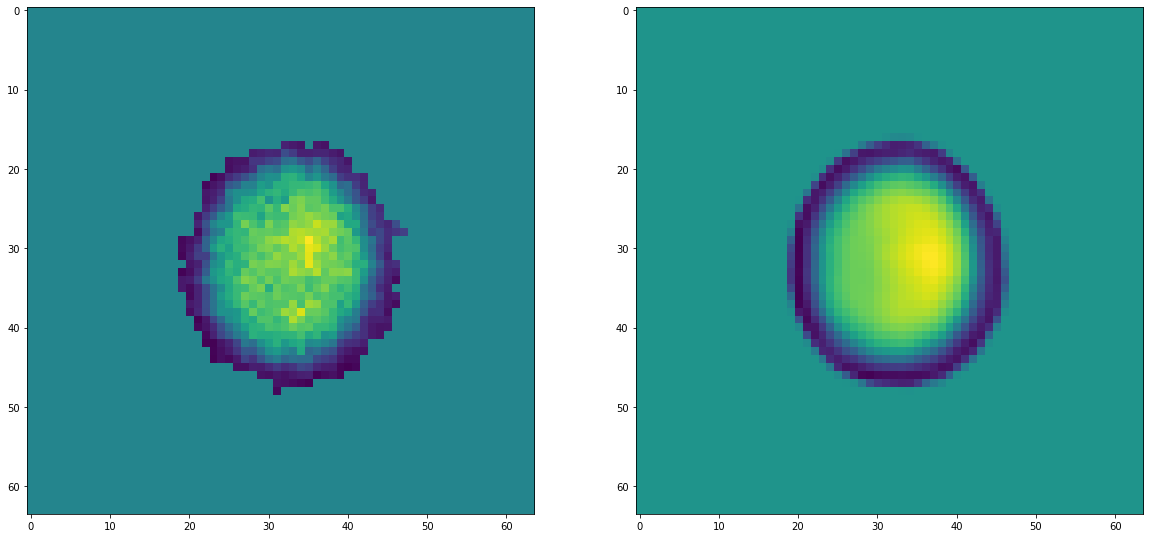

In [17]:
X, y = train_iter.next()
img = X['image']
temp = vae_model(img)
embedding = vae_model.encoder(img)
rec = vae_model.decoder(embedding[0])
# rec = vae_model.decoder(vae_model.prob_encoder(embedding))

fig, axes = plt.subplots(1,2,figsize=(20,20))
print(img.shape)
axes[0].imshow(img[0,0,:,:,0])
axes[1].imshow(rec[0,0,:,:,0])

  0%|          | 0/5000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Latent space')

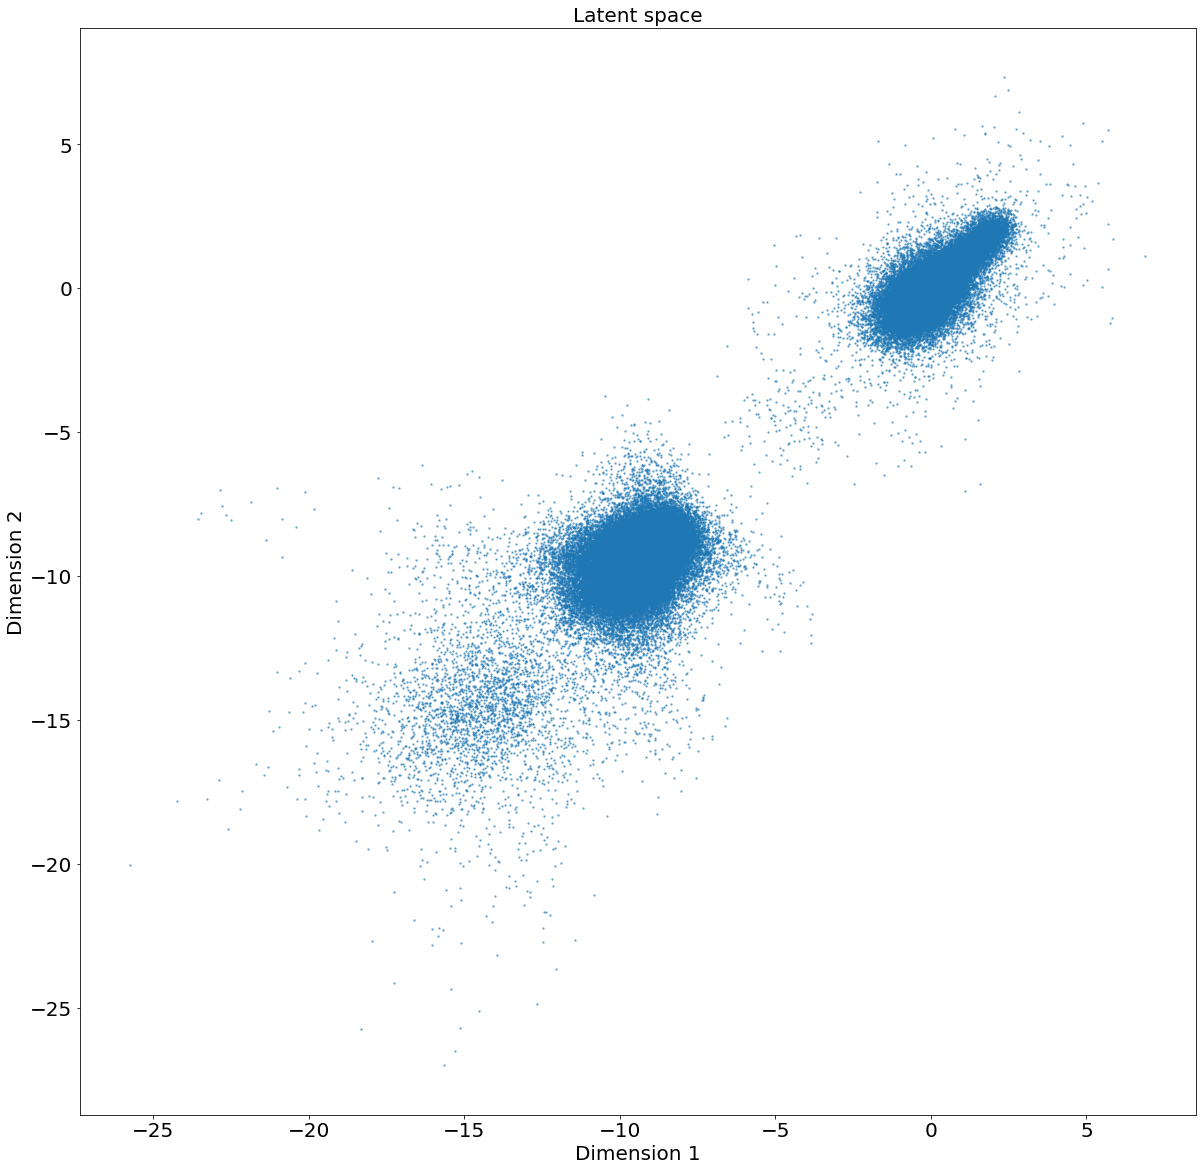

In [18]:
n_to_show=5000
embedding_list = []
for i in tqdm(range(n_to_show)):
    X, y = train_iter.next()
    img = X['image']
    embedding = vae_model.encoder(img)
    embedding_list.append(embedding)

embeddings = np.concatenate(embedding_list, axis=0)
plt.figure(figsize=(20,20))
plt.scatter(embeddings[:,0], embeddings[:,1], alpha=0.5, s=2)
plt.xlabel('Dimension 1', size=20)
plt.ylabel('Dimension 2', size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.title('Latent space', size=20)